# Surrogate Models

## 1. Linear Regression with One Variable

> Imagine we want to derive a linear regression model that approximates the relationship between the yield
strength and tensile strength values of a polymer data set. The dataset presents samples where yield strength and tensile strength values liespectively in the ranges (1MPa - 25MPa) and (1MPa - 23MPa).



### 1.1 Plotting the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('default')
plt.style.use('seaborn-v0_8-darkgrid')
plt.style.use('seaborn-v0_8-poster')

In [2]:
df = pd.read_csv('data.txt', sep=',', header=None)
df.columns = ['yield_strength', 'tensile_strength']

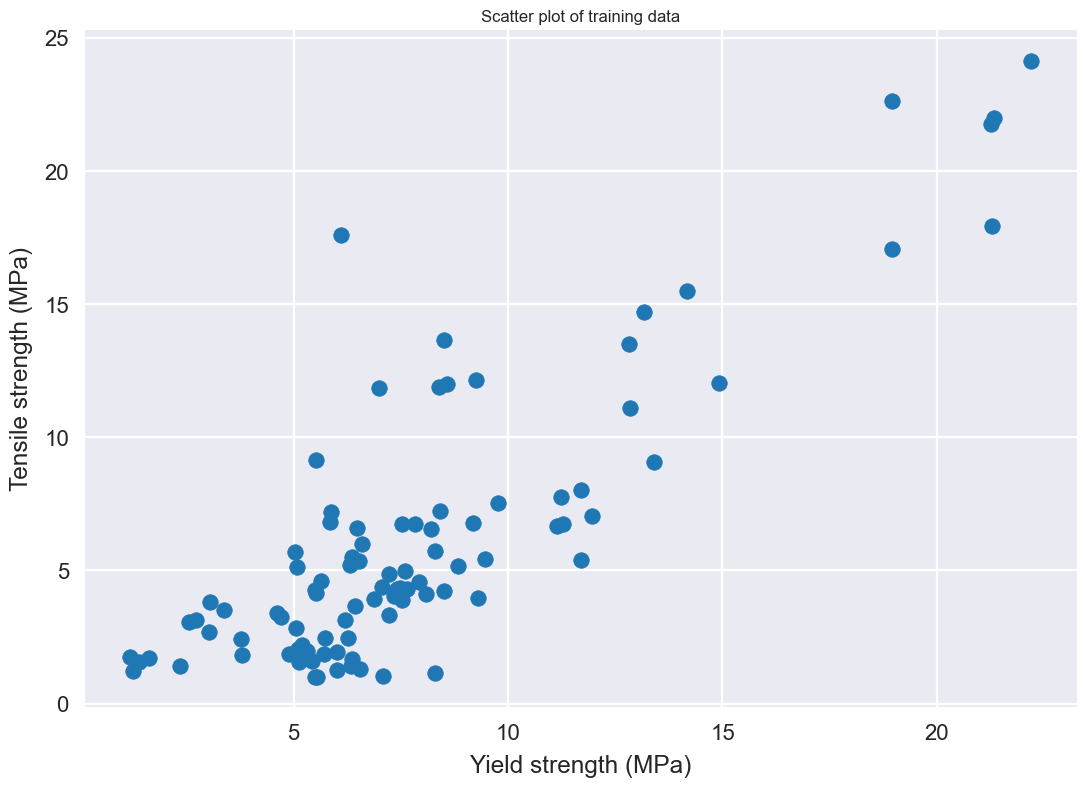

In [3]:
# ---- plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(df['yield_strength'],df['tensile_strength'])
# -- lables
ax.set_xlabel('Yield strength (MPa)',labelpad=8)
ax.set_ylabel('Tensile strength (MPa)',labelpad=8)
plt.title('Scatter plot of training data', fontsize = 12)

plt.show()

The plot shows that they have a linear relationship.

## Exercise 1

Implement the closed-form solution to find the $\beta$ coefficients of the linear regression model.

$$\hat{\beta} = (X^TX)^{-1}X^Ty$$

In [5]:
X = df['yield_strength'].to_numpy()
y = df['tensile_strength'].to_numpy()

print(X.shape)
print(y.shape)


(97,)
(97,)


In [8]:
# Implement a function to apply the closed-form formula above

def normal_eqn(X, y):
##### Enter your code here:
    return np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(X),X)),np.transpose(X)),y)

#####

In [16]:
Xe = np.hstack((np.ones((len(X),1)),X.reshape(len(X),1)))
beta_e = (np.linalg.inv(Xe.T @ Xe) @ Xe.T @ y)
# beta_e = normal_eqn(Xe, y)
beta_e

array([-1.77307489,  1.01320097])

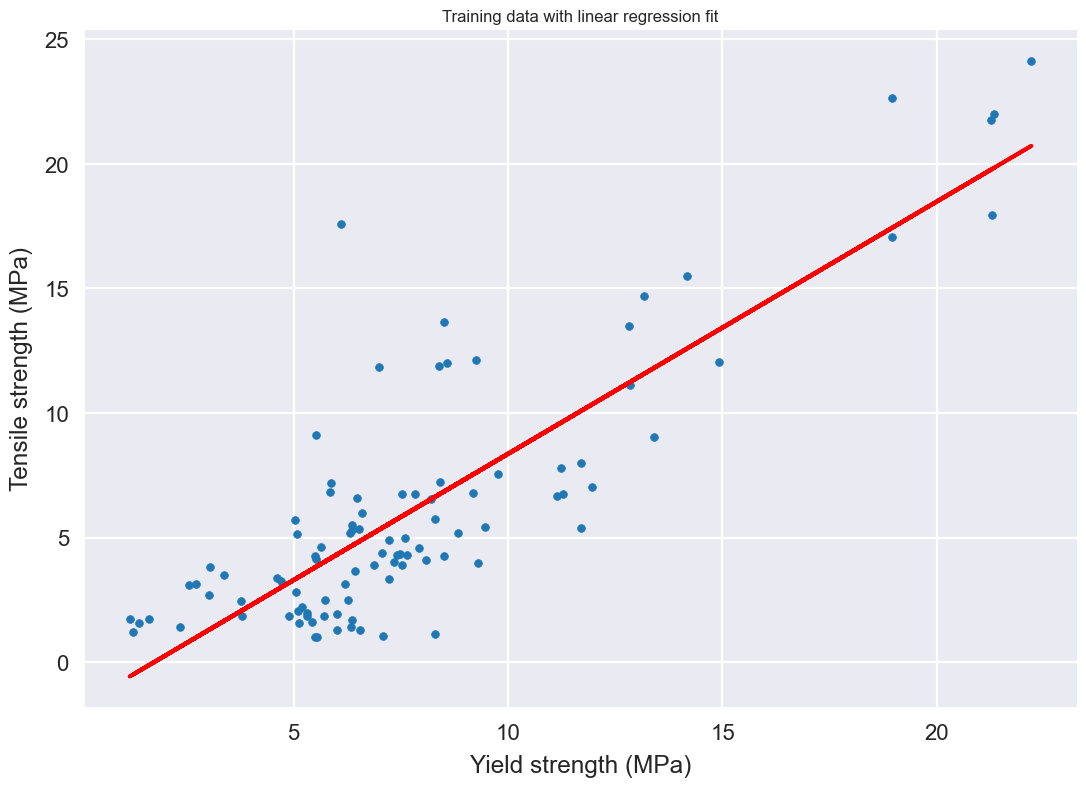

In [17]:
# Plotting results (scatter plot plus linear fit)

# ---- plot
fig = plt.figure()
ax = fig.add_subplot(111)

##### Enter your code here:

# Plot the scatter plot
ax.scatter(X,y,marker='.')

# Plot the regression
y_hat = Xe@beta_e
ax.plot(X,y_hat,'r')
#####

# -- lables
ax.set_xlabel('Yield strength (MPa)',labelpad=8)
ax.set_ylabel('Tensile strength (MPa)',labelpad=8)
plt.title('Training data with linear regression fit', fontsize = 12)

plt.show()




Play around with your model to predict the tensile strength value at unexplored values for the yield strength parameters. Generate an output as the one shown below for as many values of x as you like.

In [18]:

# Example of prediction printing

##### Enter your code here:
yield_str = 17.9
pred = beta_e[0]+yield_str*beta_e[1]
resp_msg = "For a yield strength of {:.3f} MPa, we predict a tensile strength of {:.3f} MPa".format(yield_str,pred)

print(resp_msg)

#####

For a yield strength of 17.900 MPa, we predict a tensile strength of 16.363 MPa


In [31]:
print(y.shape)

(97,)


## Exercise 2: Solution Code using Scikit-Learn

Scikit-Learn has a method which performs linear regression for you. Use the `fit` method from the class `LinearRegression` to find the same solution as the one found implementing the closed-form formula (print the intercept and coefficient beta values to screen to check).

If you don't have the package installed, add it by activating your environment and running `conda install scikit-learn` on your shell.


In [19]:
##### Enter your code here:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X.reshape(-1, 1), y.reshape(-1, 1))

print(reg.intercept_,reg.coef_)



#####

[-1.77307489] [[1.01320097]]


## 2. Assess Meta-model Quality

One of the quality metrics for regression models we have seen is the Coefficient of Determination $R^2$. It helps determine how well the model is blend and how well the output value is explained by the determining (independent) variables of the dataset.The closer the value to 1, the best the model prediction. Let's remember the formula:

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$

where 
- $SS_{res}$ represents the sum of squares of the residual errors of the data model.
- $SS_{tot}$ represents the total sum of the errors.






## Exercise 3
### Part 1
Code the $R^2$ formula above. Take 15 random points from the data used in Exercise 1 and compute $R^2$ based on those.

In [33]:
def my_coefficient_determination(y, pred):
    ##### Enter your code here:
    # Compute the sum of squares of residual errors
    SST = np.sum(np.power((y.reshape(-1,1)-np.mean(y.reshape(-1,1))),2))
    SSE = np.sum(np.power((y.reshape(-1,1)-pred.reshape(-1,1)),2))
    return (1-SSE/SST)
    
    ##### 


In [34]:
# Extracting 15 random points from the sample and computing approximated values

##### Enter your code here:
# Enter the random mask

random_mask = np.sort(np.random.choice(len(y), 15, replace=False))
print(random_mask)

# Slice the arrays
y_rand = y[random_mask]

y_pred = reg.predict(X.reshape(-1,1)[random_mask])


##### 

# Computing coefficient of determination value
r = my_coefficient_determination(y_rand,y_pred)
print('Coefficient of Determination:', r) 


[ 5  6  7  9 12 15 17 18 29 45 52 63 71 78 83]
Coefficient of Determination: 0.7633062534494793


The value for $R^2$ is quite low, meaning that the linear model is not suitable for approximating the data or that the measures are affected by severe noise.

### Part 2
Sklearn has the built-in method `r2_score` to compute the coefficient of determination. Use it to verify that you did not make any mistakes in the first part of the exercise. 

In [35]:
##### Enter your code here:
from sklearn.metrics import r2_score
R_square = r2_score(y_rand, y_pred)

##### 

print('Coefficient of Determination from Sklearn:', R_square) 

Coefficient of Determination from Sklearn: 0.7633062534494793


## 3. Polynomial models of different degrees

We now see an example from Scickit-learn about polynomial models of different degrees and how they approximate the data. We will see that a linear function (polynomial with degree 1) is not sufficient to fit the training samples (UNDERFITTING). A polynomial of degree 4 approximates the true function almost perfectly. Instead, for higher degrees the model OVERFITS the training data, i.e., it learns the noise of the training data. 

The quality of the models is evaluated by using cross-validation with 10 folds.

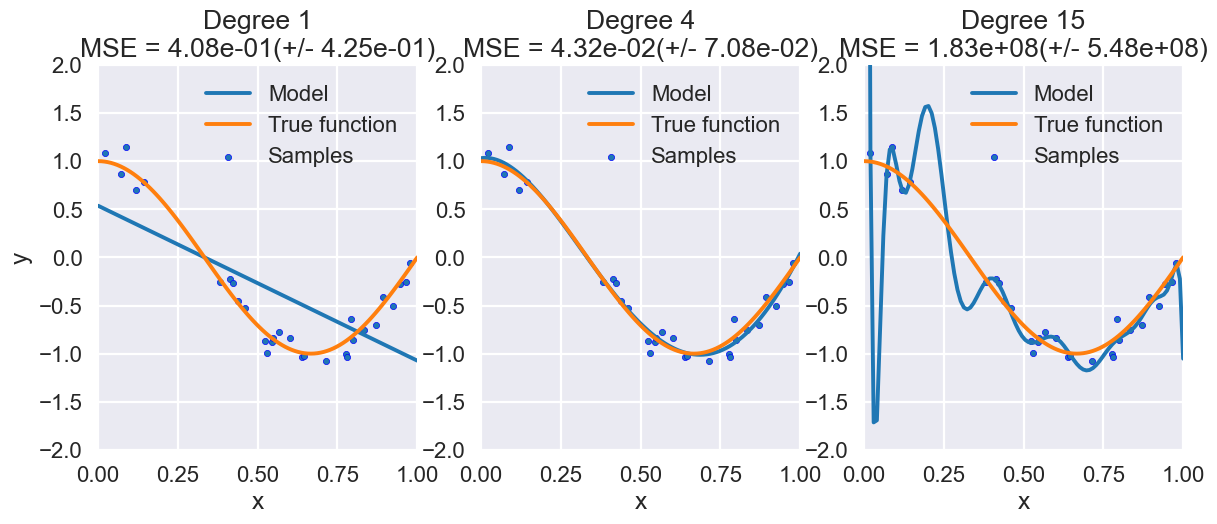

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# Initialization of random seed
np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

# Adding noise to the true function to generate our sample
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    # plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    # Fitting the estimator
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    if i == 0:
        plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D

In [38]:
def f(X):
    # 1D example function to illustrate Gaussian process
    x = X
    return x * np.cos(x) + 10

def Ackley(x1, x2):
    # Usually evaluated on [-5,5]^2
    # Global minimum at (0, 0) where f(x1, x2) = 0
    return -20*np.exp(-0.2*np.sqrt(0.5*(x1**2+x2**2))) - np.exp(0.5*(np.cos(2*np.pi*x1)+np.cos(2*np.pi*x2))) + 20 + np.e

def Rosenbrock(x1, x2): 
    # Usually evaluated on [-2,2]^2
    # Global minimum at (a,a^2) where f(x1,x2)=0
    a = 1
    b = 100     
    return (a-x1)**2 + b*(x2 - x1**2)**2

def Quadratic(x1, x2):
    # Can be evaluated on any search domain
    # Global minimum at (0,0) where f(x1,x2)=0
    return x1**2 + x2**2

In [39]:
#Euclidean norm in R
def norm(x1, x2):
    return np.abs(x1 - x2)

Commonly used types of radial basis functions include:

- Gaussian kernel: $ \varphi (r) = e^{-\frac{(\varepsilon r)^{2}}{2L^2}} $
- Multiquadric kernel: $ \varphi (r) = \sqrt{1+(\varepsilon r)^{2}} $
- Inverse quadratic kernel: $ \varphi (r) = \frac{1}{1+(\varepsilon r)^{2}}  $
- Inverse multiquadric kernel: $ \varphi (r) = \frac{1}{\sqrt{1+(\varepsilon r)^{2}}}  $

where $r$ is the distance from the center of the basis and $\varepsilon$ is a shape parameter that can be used for scaling the input of the kernel.

## Exercise 4
- Implement the isotropic kernels above, taking the radius as input and returning the value of the basis at the given radius (i.e., distance from the center of the basis). 
- By trying our several values for $\varepsilon$, observe how the plot of the kernel functions changes and find the value returning the plot below.

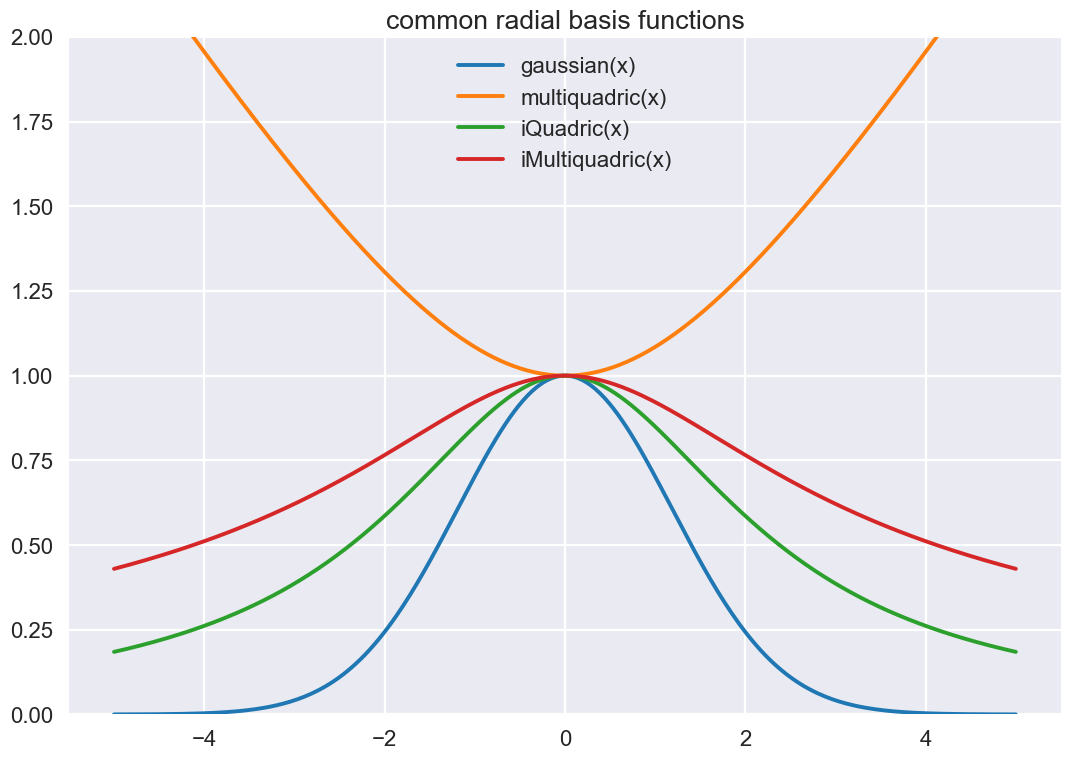

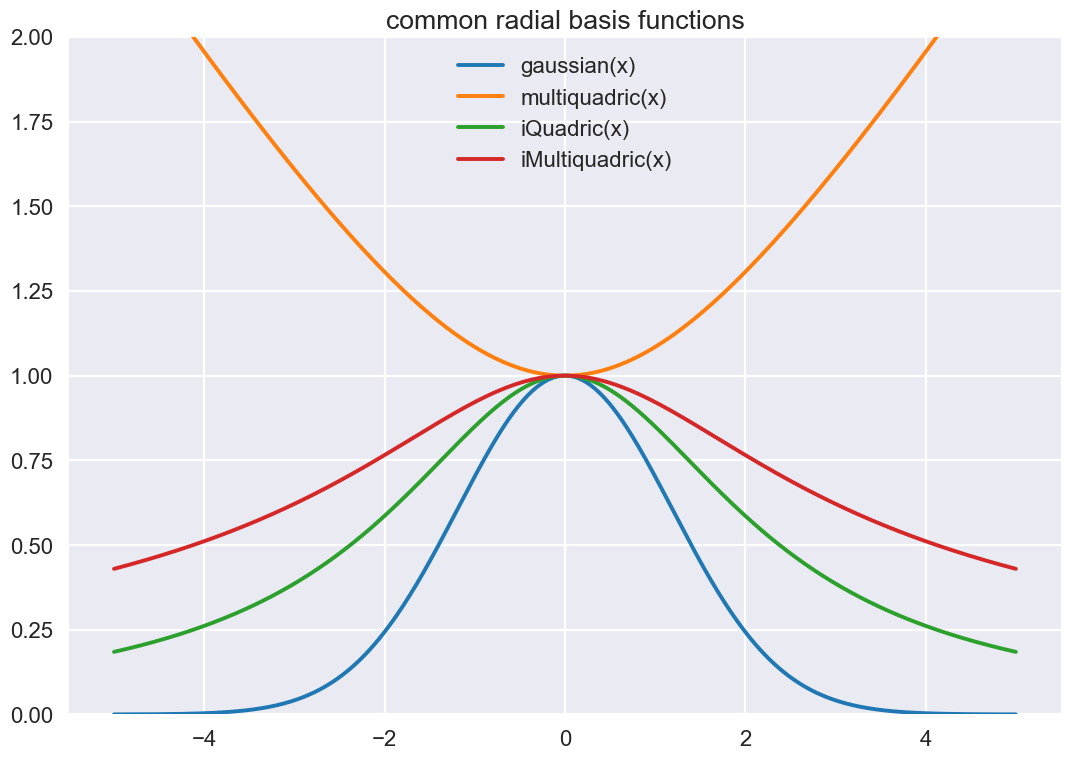

In [40]:

L = 0.5 # lengthscale


##### Enter your code here:

e = 0.4202 # epsilon

# gaussian 
def gaussian(x):
    return np.exp(-np.power(e*x,2)/(2*L**2))

# multiquadric
def multiquadric(x):
    return np.sqrt(1 + np.power(e*x,2))

# inverse quadric
def iQuadric(x):
    return 1/(1 + np.power(e*x,2))

# inverse multiquadric
def iMultiquadric(x):
    return 1/(np.sqrt(1 + np.power(e*x,2)))

#####

# Grid for plotting
x = np.linspace(-5, 5, 400)
# Distance from the center
r = np.absolute(x)

plt.plot(x, gaussian(r), label = 'gaussian(x)' )
plt.plot(x, multiquadric(r), label = 'multiquadric(x)' )
plt.plot(x, iQuadric(r), label = 'iQuadric(x)' )
plt.plot(x, iMultiquadric(r), label = 'iMultiquadric(x)' )

plt.title("common radial basis functions")
plt.ylim(0, 2)
plt.legend(loc="upper center")
plt.show()

Read the following example of Gaussian Kernel from sklearn

True


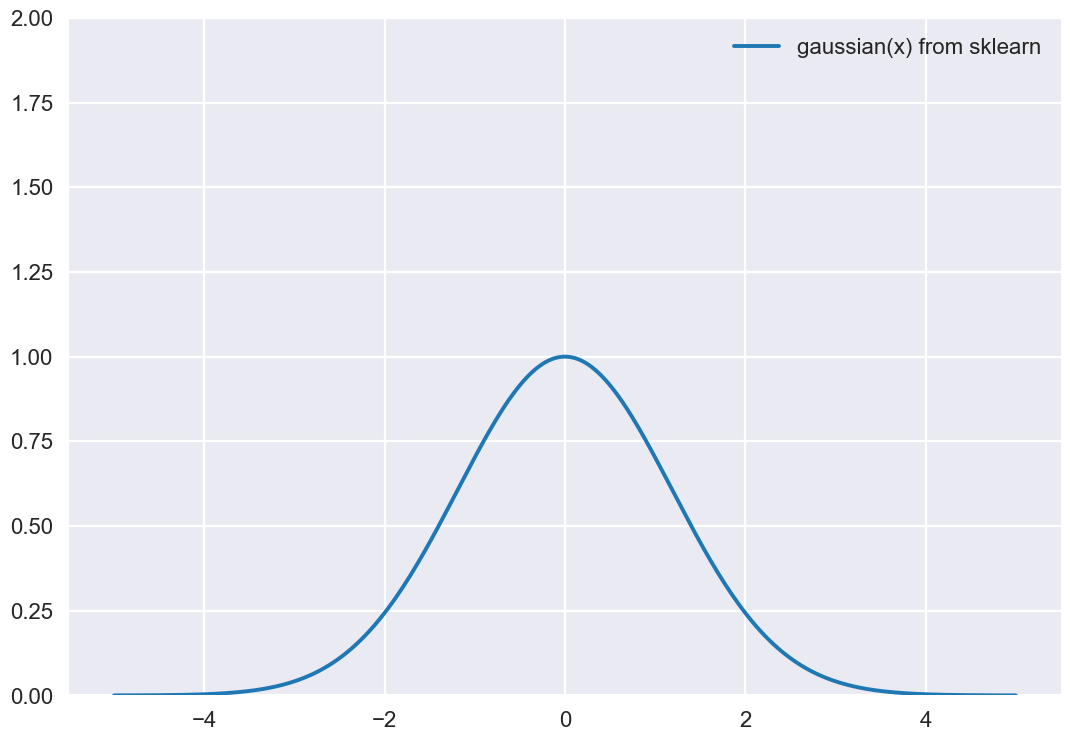

In [41]:
# Example of Gaussian kernel application from sklearn

from sklearn.gaussian_process.kernels import RBF


sklearn_gaussian = np.power(RBF(length_scale=0.5), e**2)
sklearn_gaussian_values, = sklearn_gaussian([[0,0]], np.column_stack((np.zeros(len(r)), r)))
our_gaussian_values = gaussian(r)
print(np.isclose(sklearn_gaussian_values, our_gaussian_values, atol=1e-9).all())

plt.plot(x, sklearn_gaussian_values, label = 'gaussian(x) from sklearn' )
plt.ylim(0, 2)
plt.legend(loc="upper right")
plt.show()

## Exercise 5
Define the method `compute_coefficients` below, which takes as input the vector of sample locations, the vector of sample observations, the name of the chosen rbf, and the norm method defined above, and gives back as output the list of coefficients (5 numbers because we have 5 points) of the linear combination giving the RBF approximation.

Suggestion: use `np.linalg.solve` to solve the linear matrix equation $Kw=y$, where $K$ is defined as:
$$ K =
\begin{bmatrix}
\varphi (\|\mathbf {x} _{1}-\mathbf {x} _{1}\|)&\varphi (\|\mathbf {x} _{2}-\mathbf {x} _{1}\|)&\dots &\varphi (\|\mathbf {x} _{n}-\mathbf {x} _{1}\|)\\\varphi (\|\mathbf {x} _{1}-\mathbf {x} _{2}\|)&\varphi (\|\mathbf {x} _{2}-\mathbf {x} _{2}\|)&\dots &\varphi (\|\mathbf {x} _{n}-\mathbf {x} _{2}\|)\\\vdots &\vdots &\ddots &\vdots \\\varphi (\|\mathbf {x} _{1}-\mathbf {x} _{n}\|)&\varphi (\|\mathbf {x} _{2}-\mathbf {x} _{n}\|)&\dots &\varphi (\|\mathbf {x} _{n}-\mathbf {x} _{n}\|)\\
\end{bmatrix}
$$

In [42]:
def compute_coefficients(xi, fi, rbf, norm):
    
    ##### Enter your code here:
    size = len(xi)
    K = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            K[i, j] = rbf(norm(xi[i], xi[j]))
            
    return np.linalg.solve(K, fi)
    #####

# define our interpolation using list comprehension
def psi(x, rbf, norm, xi, fi):
    wi = compute_coefficients(xi, fi, rbf, norm)
    return [ np.sum([wi_*rbf(norm(x_, xi_)) for xi_, wi_ in zip(xi, wi)]) for x_ in x]

C:\Users\kiral\AppData\Local\Temp\ipykernel_21456\3235851756.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  K[i, j] = rbf(norm(xi[i], xi[j]))


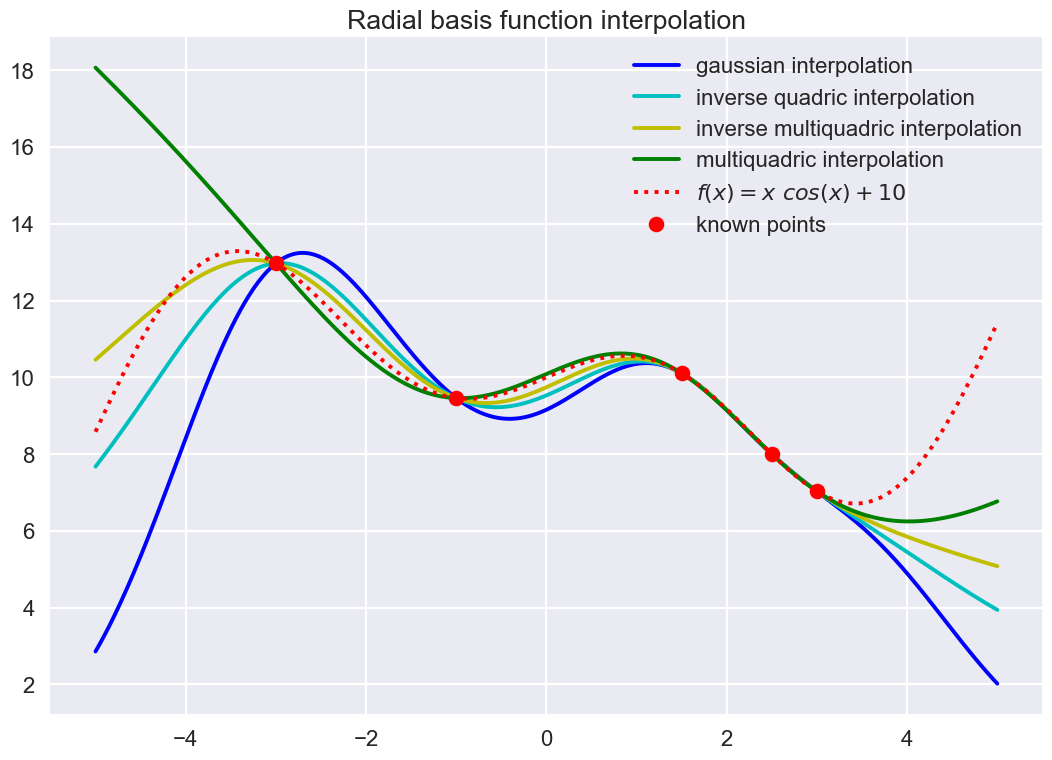

In [43]:
# define our known points and their measurements
# We start with a 1D simple example
# Sampling locations
xi = np.atleast_2d([-3., -1, 1.5, 2.5, 3]).T

# Sample observations
fi = f(xi).ravel()


plt.plot(x, psi(x, gaussian, norm, xi, fi), '-b', label = 'gaussian interpolation')
plt.plot(x, psi(x, iQuadric, norm, xi, fi), '-c', label = 'inverse quadric interpolation')
plt.plot(x, psi(x, iMultiquadric, norm, xi, fi), '-y', label = 'inverse multiquadric interpolation')
plt.plot(x, psi(x, multiquadric, norm, xi, fi), '-g', label = 'multiquadric interpolation')
plt.plot(x, f(x), 'r:', label='$f(x) = x\ cos(x) + 10$')
plt.plot(xi, fi, 'or', label = 'known points')

plt.title('Radial basis function interpolation')
plt.legend(loc='upper right')
plt.show()

# Exercise 6

Finished all the tasks? 
Did not manage to install Python?
Interpreter does not interprete?

Not a problem! This task is specifically for you. Forget about the code and enjoy the beauty of interpolation :)

### Subproblem 6.1: Hacking Linear Regression

In Exercise 1 you implemented the solution for Linear Regression $$\mathbf{\hat{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}.$$
Now find such a data set $\left( \mathbf{X}, \mathbf{y} \right)$ that leads to an error when making computations of $\mathbf{\hat{\beta}}$ according to the latter formula.

- Why does it fail on some data sets?
- Does a solution to Linear Regression always exist?
- Is the solution of Linear Regression always unique?

### Subproblem 6.2: When strong polynomials lose powers they become weak and linear...

Consider the following class of polynomail functions, where $n \in \mathbb{N}$ is a fixed constant:
$$p(\mathbf{\beta}, x) = \sum\limits_{k=0}^n \beta_k x^k.$$

If $\mathbf{x} \in \mathbb{R}^{N \times 1}, \mathbf{y} \in \mathbb{R}^{N \times 1}$ is the training data and loss is computed using the following functional $$ \mathscr{L}(p, \mathbf{\beta}, \mathbf{x}, \mathbf{y}) =\sum_{k=1}^N \left(p(\mathbf{\beta}, x_k) - y_k \right)^2,  $$
then solving regression problem is equivalent to locating any $\mathbf{\beta}^* \in \mathbb{R}^{n+1}$ such that 
$$ \mathscr{L}(p, \mathbf{\beta}^*, \mathbf{x}, \mathbf{y}) = \min\limits \left\{ \mathscr{L}(p, \mathbf{\beta}, \mathbf{x}, \mathbf{y}) \,\middle\vert\, \mathbf{\beta} \in \mathbb{R}^{n+1} \right\}. $$

- How can you solve this optimization problem?
- Can you derive a closed-form solution?
- When does the solution of this problem exist and when is it unique?
- Can you generalize your statements to the case when $\mathbf{X} \in \mathbb{R}^{N \times M}, M > 1$?
- What happens if $n \in \mathbb{N}$ is not a constant, but a varaible as in $p(\mathbf{\beta}, x, n)$?

### Subproblem 6.3: In Hilbert Space a Piece of Cake Never Finishes!

Imagine that your data set $\mathbf{X} \in \mathbb{R}^{n \times m}, \mathbf{Y} \in \mathbb{R}^{n \times 1}$ is such that solution to linear regression problem with this data is unique. Given kernel function $\varphi : \mathbb{R} \to \mathbb{R}$, prove that there exists a unique $\mathbf{w} \in \mathbb{R}^n$ such that $\mathbf{K} \mathbf{w}=\mathbf{Y}$, where $\mathbf{K}$ is (still) defined as:
$$ \mathbf{K} =
\begin{bmatrix}
\varphi (\|\mathbf {X} _{1}-\mathbf {X} _{1}\|)&\varphi (\|\mathbf {X} _{2}-\mathbf {X} _{1}\|)&\dots &\varphi (\|\mathbf {X} _{n}-\mathbf {X} _{1}\|)\\\varphi (\|\mathbf {X} _{1}-\mathbf {X} _{2}\|)&\varphi (\|\mathbf {X} _{2}-\mathbf {X} _{2}\|)&\dots &\varphi (\|\mathbf {X} _{n}-\mathbf {X} _{2}\|)\\\vdots &\vdots &\ddots &\vdots \\\varphi (\|\mathbf {X} _{1}-\mathbf {X} _{n}\|)&\varphi (\|\mathbf {X} _{2}-\mathbf {X} _{n}\|)&\dots &\varphi (\|\mathbf {X} _{n}-\mathbf {X} _{n}\|)\\
\end{bmatrix}
$$


# Solutions to Exercise 6

### Solution to 6.1

Computations according to the given formula fail on any matrix $\mathbf{X}$ with linear dependency between columns because $\mathbf{X}^T \mathbf{X}$ is singular in this case.
Indeed, if for $\mathbf{y} \ne 0$ we have $\mathbf{X}\mathbf{y} = 0$ then  $\mathbf{X}^T \mathbf{X} \mathbf{y} = 0$.
So the inverse of $\mathbf{X}^T \mathbf{X}$ does not exist.

However, at least one solution regarding $\mathbf{\beta}$ of the following equation always exits! 

$$\mathbf{X}^T\mathbf{X}\mathbf{\beta} = \mathbf{X}^T\mathbf{y}$$

It is simple to see if we consider the left and light parts as linear operators instead of matrixes.
Indeed, null spaces of operators $\mathbf{X}^T\mathbf{X}$ and $\mathbf{X}$ are equal, which implies that images of operators $\mathbf{X}^T\mathbf{X}$ and $\mathbf{X}^T$ are also equal. Therefore there exists at least one $\mathbf{\beta}$ that $\mathbf{X}^T\mathbf{X}\mathbf{\beta}$ gives the same element as $\mathbf{X}^T\mathbf{y}$. The solution is unique if and only if matrix $\mathbf{X}$ does not have linear dependent columns. So Linear Regression problems always have at least one solution, which may not be unique.

### Solution to 6.2

The optimization problem can be solved using conventional optimization methods. However, a closed-form solution can be obtained. Consider the matrix $\mathbf{X} = \left\{ x_i^j \right\}_{i = 1, N, \; j = 0, n}.$
Then locating $\mathbf{\beta}^*$ boils down to solving Linear Regression with data set $\mathbf{X}, \mathbf{y}$.
As we already understand, its solution always exists, but may not be unique.
Generalization to the case of multidimensional data can be done analogically. 

However, when $n$ is a variable, the size of matrix $\mathbf{X}$ depends on $n$, and therefore, our reduction to Linear Regression is not valid.
However, one can use the Lagrange Interpolation Polynomial that exactly fits $n$ data points with polynomials of degree not greater than $n-1$.
Therefore, it is guaranteed that for $n = N + 1$ the value of the loss is zero and the corresponding polynomial is known constructively. 

### Solution to 6.3

In the previous example, it might be inconvenient when there is no linear dependence in columns of $\mathbf{x}$, however, columns of $ \left\{ x_i^j \right\}$ turn out to be linearly dependent.
We ensure that it never happens by application of the kernel function.

If there is no linear dependency in columns of $\mathbf{X}$ then the Gram matrix $\mathbf{K}$ is strictly positive definite. 
Therefore, we get the unique solution of the given regression problem in the following form: $\mathbf{w} = \mathbf{K}^{-1} \mathbf{Y}.$